# Algorithmic Trading with Reinforcement Learning

The integration of powerful computer models and methods is primarily responsible for the profound change in the financial trading scene, and algorithmic trading is a sector at the forefront of this change. To develop trading strategies, exploit small market inefficiencies and make precise trading decisions with a speed and frequency that exceeds human capabilities, traders are increasingly relying on algorithmic trading.

Finding an algorithmic method to outperform a stock market index has been the subject of much research and an exceptionally difficult problem to solve. However, recent advances in Deep Reinforcement Learning (DRL) offer a new way to break away from traditional machine learning models, and the initial research results are promising. For example, Briola et al (2021), demonstrated the utility of DRL algorithms in tracking important market trends and adjusting positions during consolidation periods \cite{briola}.

Why Deep Reinforcement Learning? In general, it allows our algorithms to learn from their actions by creating a feedback loop to improve performance. By applying this approach to the stock market, I hope to gain insights into the potential, but also the limitations, of AI in financial decision making.

We'll compare a proven conventional trading method, represented by the player Kane, with a DRL-based strategy, represented by the player Abel. While Abel uses a DRL model to dynamically change his trading decisions in response to market behaviour, the standard approach uses a traditional technique such as dollar-cost averaging. The main hypothesis is that Abel's adaptive DRL method will allow him to outperform Kane's traditional approach in terms of return on capital and risk-adjusted ratios.

This project builds on similar work, such as Deng et al. (2017), who demonstrated the success of reinforcement learning on continuous futures contracts by outperforming classic time-series momentum strategies even after taking into account high transaction costs that are common in this type of trades \cite{ddrl}.

By conducting this project, I aim to better understand the potential and limitations of using artificial intelligence, particularly DRL, in financial decision making. The results could be of great importance to traders and investors, potentially giving them a better way to navigate the complex and unstable world of financial markets.

## Setup

### Import modules

In [1]:
import random
import copy
import torch
import math
import warnings
import numpy as np
import yfinance as yf
import pandas as pd
import gymnasium as gym
import matplotlib.pyplot as plt
from gymnasium.envs.registration import register
from torch import nn as nn
import torch.nn.functional as F
from torch.optim import AdamW
from torch.optim.lr_scheduler import StepLR
from tqdm import tqdm
from IPython.display import display, HTML
import matplotlib.dates as mdates
from datetime import datetime, timedelta

### Compute

In [2]:
# This project is running on an M1 Mac, make sure PyTorch uses Metal API for increased performance
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"PyTorch will use {device} for compute")

PyTorch will use mps for compute


### Variables

In [3]:
tickers = ['SPY', 'AAPL', 'MSFT'] # Tickers to be tested
trading_days = 1000 # Number of trading day for which to run the test
investable_cash = 10000 # Amount of stanting cash balance, in USD
volatility_rolling_window = 5 # Number of trading days, 5 days = one trading week
TARGET_UPDATE_RATIO = 0.005 # A constant to determine the degree of soft update for target network in Q-learning.

### Download required data sets

In [4]:
stock_dfs = {}

for ticker in tickers:
    stock_dfs[ticker] = yf.download(ticker)
    stock_dfs[ticker] = stock_dfs[ticker][["Adj Close", "Volume"]].tail(trading_days)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


## Gymnasium environment

In [5]:
# Register our custom environment (implemented in ./custom_env)
register(
    id="custom_gym/StockEnv-v0",
    entry_point="custom_gym.envs:StockEnv",
)

# Reimport the environment, so that it is visible to other Gymnasium modules
import custom_gym.envs

### Wrap the environment for compatibility with PyTorch
By default, the environment methods return a Python list that is not compatible with PyTorch. This wrapper converts the output of the step and reset functions into Tensors.

In [6]:
class PreprocessEnv(gym.Wrapper):
    def __init__(self, env):
        gym.Wrapper.__init__(self, env)

    def reset(self):
        observation = self.env.reset()[0]
        # We work with batches of observations, add an extra dimension to make sure PyTorch can parse it
        return torch.from_numpy(observation).unsqueeze(dim=0).float()

    def step(self, action):
        action = action.item()
        # Run the step as normal
        next_state, reward, terminated, _, _ = self.env.step(action)
        # Convert values to Tensors + add a dimension as described in the reset function
        next_state = torch.from_numpy(next_state[0]).unsqueeze(dim=0).float()
        terminated = torch.tensor(terminated).view(1, -1)
        reward = torch.tensor(reward).view(1, -1).float()

        return next_state, reward, terminated, False, _

## Q-Network and policy

### Structure
* The input layer maps to the observation space (state) of the environment. 
* The output layer maps to the action space of the environment, because the main purpose of this network is to determine an action with the highest probability of best reward, weighted over time (with respect to overall returns).
* Batch normalisation (BatchNorm) can help deep neural networks in particular to function better and remain stable. By subtracting the batch mean and dividing by the standard deviation of the batch, the output of a previous activation layer is normalised, keeping the activation mean close to 0 and the activation standard deviation close to 1. This can speed up convergence and serve as regularisation at the same time. There are a few things to consider for a Q-network in reinforcement learning:
    * Exploration: The state statistics and hence the activations within the neural network may change over time if the environment is non-stationary (e.g. as a result of an epsilon greedy exploration strategy). In these circumstances BatchNorm helps by minimising the internal covariate shift.
    * Generalisation: With different input distributions, the normalisation effect can help the network to generalise better.
    * Training stability: BatchNorm can stabilise the training, especially for deeper networks.

![Neural network](images/q-network.png "Q-Network")

### Implementation

In [7]:
class QNetwork(nn.Module):
    def __init__(
        self,
        state_dims,
        hidden_dim1=256,
        hidden_dim2=128,
        num_actions=3,
        use_bn=True,
        dropout_rate=0.5,
    ):
        super(QNetwork, self).__init__()
        self.use_bn = use_bn

        # Layers
        self.fc1 = nn.Linear(state_dims, hidden_dim1) # Input layer
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2) # Hidden layer
        self.fc3 = nn.Linear(hidden_dim2, num_actions) # Output layer

        # Batch normalization layers
        self.bn1 = nn.BatchNorm1d(hidden_dim1)
        self.bn2 = nn.BatchNorm1d(hidden_dim2)

        # Dropout layers
        self.dropout1 = nn.Dropout(dropout_rate)
        self.dropout2 = nn.Dropout(dropout_rate)

    # This effectively defines structure of the NN
    def forward(self, x):
        x = self.fc1(x)
        # No point in adding batch normalization if batch size is less than 1
        if self.use_bn and x.size(0) > 1:
            x = self.bn1(x)

        x = F.relu(x)
        x = self.dropout1(x)

        x = self.fc2(x)
        if self.use_bn and x.size(0) > 1:
            x = self.bn2(x)
        x = F.relu(x)
        x = self.dropout2(x)

        x = self.fc3(x)
        return x


### Exploratory policy

The epsilon greedy policy allows an agent to generally follow the best course of action while occasionally experimenting with new courses of action. This achieves a balance between exploration and exploitation. A regular policy, on the other hand, can get caught up in local optima and miss out on finding potentially better actions or tactics because it consistently selects the option currently perceived as optimal (pure exploitation). The Epsilon Greedy method ensures that the agent keeps taking in new information about its environment during training so that it can adapt to new situations or changes in the environment.

In [8]:
def policy(state, num_actions, q_network, epsilon=0.1):
    if torch.rand(1) < epsilon:
        # Epsilon greedy part
        return torch.randint(num_actions, (1, 1))
    else:
        av = q_network(state).detach()
        return torch.argmax(av, dim=-1, keepdim=True)

## Experience Replay buffer

Two main problems of reinforcement learning are addressed by the experience buffer and experience repetition:

1. Sequential data correlation: strong correlations are possible between ongoing streams of knowledge. Training a model with these sequential experiences can lead to ineffective learning as the model may be biassed or trapped in local optima. Repetition of experiences breaks the temporal correlations by storing these events and then randomly selecting from them, resulting in more stable and robust learning.
2. In classical reinforcement learning, an experience (state, action, reward, next state) is used only once to update the model before it is deleted. The ability to replay previous events allows the agent to learn from them again and ensures that unusual or significant encounters have an impact on the agent's learning.

In [9]:
class ExperienceBuffer:
    """
    This class provides a cyclic buffer with limited capacity to store transitions.
    It can be used to accumulate and store reinforcement learning experience.
    """
    
    def __init__(self, max_size=200000):
        self.max_size = max_size
        self.buffer = []
        self.next_idx = 0

    def store(self, transition):
        if len(self.buffer) < self.max_size:
            self.buffer.append(None)
        
        self.buffer[self.next_idx] = transition
        self.next_idx = (self.next_idx + 1) % self.max_size

    def retrieve_sample(self, sample_size):
        assert self.is_sample_possible(sample_size)

        sampled_transitions = random.sample(self.buffer, sample_size)
        grouped_by_attribute = zip(*sampled_transitions)
        return [torch.cat(group) for group in grouped_by_attribute]

    def is_sample_possible(self, sample_size):
        return len(self.buffer) >= sample_size * 10

    def __len__(self):
        return len(self.buffer)

## Deep Q-Learning algorithm

Deep Q-learning is a sophisticated reinforcement learning method that combines deep neural networks and conventional Q-learning. The main goal is to estimate the action value function Q(s, a), which predicts the expected payoff (cumulative future rewards) for performing an action on in state s. Unlike conventional Q-learning, which uses a table to record these Q-values, Deep Q-learning approximates Q(s, a) using a neural network.

An agent interacts with its environment while being trained, collects experience in the form of tuples (state, action, reward, future state) and stores them in a replay memory. To update the Q-network, a batch of experiences is taken from this memory at regular intervals.

Q-networks use an off-policy learning by utilizing a second target network, which is a duplicate of the original Q-network, and is used to stabilise learning. This is different to on-policy approaches, such as SARSA, which use the same network. The main objective is to reduce the discrepancy between the target and projected Q-values by gradient descent. The agent is able to make more ideal judgements as the Q-network becomes better at guessing the true Q-values over time.

In [10]:
def soft_target_update(target_network, main_network, update_ratio):
    """
    Softly update the target network parameters using parameters from the main network.
    """
    for target_param, main_param in zip(
        target_network.parameters(), main_network.parameters()
    ):
        target_param.data.copy_(
            update_ratio * main_param.data + (1.0 - update_ratio) * target_param.data
        )


def calculate_epsilon(episode, start=1.0, end=0.01, decay_period=100):
    """
    Calculates the epsilon value for epsilon-greedy policy, decaying over time to shift from exploration to exploitation.
    """
    return end + (start - end) * np.exp(-episode / decay_period)


def train_deep_q_learning(
    env,
    main_q_network,
    target_q_network,
    policy_fn,
    num_actions,
    total_episodes,
    learning_rate=0.0001,
    batch_size=128,
    discount_factor=0.99,
):
    """
    Train a deep Q-network using Double DQN.
    """
    optimizer = AdamW(main_q_network.parameters(), lr=learning_rate)
    # Adjust the learning rate every 50 episodes by multiplying it with 0.9.
    lr_scheduler = StepLR(optimizer, step_size=50, gamma=0.9)

    experience_buffer = ExperienceBuffer()
    training_stats = {"Returns": [], "Info": [], "MSE Loss": []}
    optimizer_called_flag = False

    for episode in tqdm(range(1, total_episodes + 1)):
        current_state = env.reset()
        episode_done = False
        episode_return = 0

        # Adjust epsilon for epsilon-greedy exploration.
        epsilon = calculate_epsilon(episode)

        while not episode_done:
            action = policy_fn(current_state, num_actions, main_q_network, epsilon)
            next_state, reward, episode_done, _, additional_info = env.step(action)

            experience_buffer.store(
                [current_state, action, reward, episode_done, next_state]
            )

            # Check if there are enough experiences to sample a batch for training.
            if experience_buffer.is_sample_possible(batch_size):
                (
                    state_batch,
                    action_batch,
                    reward_batch,
                    done_batch,
                    next_state_batch,
                ) = experience_buffer.retrieve_sample(batch_size)
                current_q_values = main_q_network(state_batch).gather(1, action_batch)

                # Double DQN logic:
                # 1. Use main Q-network to determine the best action for the next state.
                # 2. Use target Q-network to calculate the Q-value of the next state given the action from step 1.
                with torch.no_grad():
                    next_actions = main_q_network(next_state_batch).argmax(
                        dim=1, keepdim=True
                    )
                    next_q_values = target_q_network(next_state_batch).gather(
                        1, next_actions
                    )

                target_values = (
                    reward_batch + ~done_batch * discount_factor * next_q_values
                )
                loss = F.mse_loss(current_q_values, target_values)

                main_q_network.zero_grad()
                loss.backward()
                optimizer.step()
                optimizer_called_flag = True

                training_stats["MSE Loss"].append(loss.item())

            current_state = next_state
            episode_return += reward.item()

        training_stats["Returns"].append(episode_return)
        training_stats["Info"].append(additional_info)

        # Update the target Q-network using the weights of the main Q-network.
        soft_target_update(target_q_network, main_q_network, TARGET_UPDATE_RATIO)

        if optimizer_called_flag:
            lr_scheduler.step()

    return training_stats


## Kane
Dollar-cost average in 10 installments.

In [11]:
def dollar_cost_average(stock_df, investable_cash, installments=10):
    trading_days_no = len(stock_df)
    interval_len = round(trading_days_no / 10)
    trading_days = np.linspace(
        0, trading_days_no - interval_len, num=installments
    ).astype("int")
    daily_budget = round(investable_cash / installments)
    cash_balance = investable_cash
    shares_owned = 0
    daily_stats = {
        "Share Price": [],
        "Shares Owned": [],
        "Cash Balance": [],
        "Share Value": [],
        "Total Value": [],
        "Returns": [],
    }

    for day in range(trading_days_no):
        share_price = stock_df.iloc[day]["Adj Close"]

        if day in trading_days:
            shares_to_buy = math.floor(daily_budget / share_price)
            shares_owned += shares_to_buy
            cash_balance -= share_price * shares_to_buy

        shares_value = share_price * shares_owned
        total_value = shares_value + cash_balance

        daily_stats["Share Price"].append(share_price)
        daily_stats["Shares Owned"].append(shares_owned)
        daily_stats["Cash Balance"].append(cash_balance)
        daily_stats["Share Value"].append(shares_value)
        daily_stats["Total Value"].append(total_value)
        daily_stats["Returns"].append(total_value - investable_cash)

    return daily_stats, total_value


## Abel

The reinforcement (deep-q) learning algorithm.

In [12]:
def rl_trade(stock_df, episodes=50, runs=5):
    all_stats = {"Returns": [], "MSE Loss": [], "Info": []}

    while len(all_stats["Returns"]) < runs:
        env = gym.make("custom_gym/StockEnv-v0", price_data=stock_df)
        torch_env = PreprocessEnv(env)
        state_dims = torch_env.observation_space.shape[0]
        num_actions = torch_env.action_space.n

        with warnings.catch_warnings():
            warnings.simplefilter("ignore")

            state = torch_env.reset()
            action = torch.tensor(0)
            next_state, reward, done, _, _ = torch_env.step(action)

        # Create a Q-network
        q_network = QNetwork(state_dims=state_dims, num_actions=num_actions)

        # Create a target Q-network
        target_q_network = copy.deepcopy(q_network).eval()

        # Run the DDQN
        stats = train_deep_q_learning(
            torch_env, q_network, target_q_network, policy, num_actions, episodes
        )

        if len(stats["Returns"]) == episodes:
            all_stats["Returns"].append(stats["Returns"])
            all_stats["MSE Loss"].append(stats["MSE Loss"])
            all_stats["Info"].append(stats["Info"])

    return all_stats


# Evaluation

Using three different stocks — SPY (SPDR S&P 500 ETF Trust), AAPL (Apple) and MSFT (Microsoft) — the performance of the deep-Q learning algorithm was compared with the conventional dollar-cost averaging method (DCA). To reduce the influence of chance on the results, each experiment was repeated five times for each stock. The DCA algorithm is deterministic and was therefore only run once.

### Visualizations

In [13]:
def plot_volatility(returns):
    # Convert data into a pandas DataFrame
    df = pd.DataFrame(returns).transpose()

    # Creating a figure with a wider size
    plt.figure(figsize=(12, 6))

    # Plot each series and its rolling standard deviation
    window_size = 5
    for i in range(df.shape[1]):
        plt.plot(df[i], alpha=0.4, label=f"Run {i+1}")
        plt.plot(
            df[i].rolling(window=window_size).std(),
            alpha=0.4,
            linestyle="--",
            label=f"Rolling Std Dev {i+1}",
        )

    # Plotting the mean series
    mean_series = df.mean(axis=1)
    plt.plot(mean_series, color="black", label="Mean Series", linewidth=2)

    # Plotting the rolling standard deviation for the mean series
    mean_rolling_std = mean_series.rolling(window=window_size).std()
    plt.plot(
        mean_rolling_std,
        color="red",
        linestyle="--",
        label="Rolling Std Dev of Mean",
        linewidth=1.5,
    )

    # Shading between mean ± standard deviation
    std_series = df.std(axis=1)
    plt.fill_between(
        df.index,
        mean_series - std_series,
        mean_series + std_series,
        color="gray",
        alpha=0.2,
        label="Mean ± Std Dev",
    )

    # Formatting the plot
    plt.title("All Runs with Aggregate Returns and Rolling Std Dev")
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
    plt.grid(True)
    plt.tight_layout()
    plt.show()


def plot_mean_with_ci(data, title, log_scale=False):
    data_array = np.array(data)
    if log_scale:
        data_array = np.log(data_array)
    mean = np.mean(data_array, axis=0)
    std = np.std(data_array, axis=0)
    plt.fill_between(range(len(mean)), mean - std, mean + std, color="b", alpha=0.2)
    plt.plot(mean, "b-", label="Mean")
    plt.title(title)
    plt.legend()


def plot_individual_runs(data, title, log_scale=False):
    for i, run in enumerate(data):
        if log_scale:
            run = np.log(run)
        plt.plot(run, label=f"Run {i+1}")
    plt.title(title)
    plt.legend()


def plot_returns(returns):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plot_mean_with_ci(returns, "Returns (Mean with CI)")
    plt.subplot(1, 2, 2)
    plot_individual_runs(returns, "Returns (Individual Runs)")

    plt.tight_layout()
    plt.show()


def plot_overlay_with_runs(data, benchmark, title):
    for i, run in enumerate(data):
        plt.plot(run, label=f"Run {i+1}")
    plt.axhline(y=benchmark, color="r", linestyle="-", label="DCA (Benchmark)")
    plt.title(title)
    plt.legend()


def plot_box_with_benchmark(data, benchmark, title):
    plt.boxplot(data)
    plt.scatter([1], [benchmark], color="r", marker="o", label="DCA (Benchmark)")
    plt.title(title)
    plt.legend()


def plot_histogram_with_benchmark(data, benchmark, title):
    flattened_data = np.array(data).flatten()
    plt.hist(flattened_data, bins=30, alpha=0.7, label="Deep-Q Returns")
    plt.axvline(x=benchmark, color="r", linestyle="-", label="DCA (Benchmark)")
    plt.title(title)
    plt.legend()


def compare_to_benchmark(ddqn_returns, benchmark_return):
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plot_box_with_benchmark(
        ddqn_returns,
        benchmark_return,
        "Episodic Returns Distribution Against the Benchmark",
    )

    plt.subplot(1, 2, 2)
    plot_histogram_with_benchmark(
        ddqn_returns, benchmark_return, "Histogram of returns"
    )

    plt.tight_layout()
    plt.show()


def visualize_ddqn_results(ticker, ddqn_stats, benchmark_return):
    display(HTML(f"<h4>Returns</h4>"))

    ddqn_df = pd.DataFrame()

    for i, run_returns in enumerate(ddqn_stats["Returns"]):
        ddqn_df[f"Run {i}"] = run_returns

    display(ddqn_df.head())
    display(ddqn_df.tail())

    plot_returns(ddqn_stats["Returns"])

    display(HTML(f"<h4>Risk and volatility</h4>"))
    plot_volatility(ddqn_stats["Returns"])

    display(HTML(f"<h4>Comparing DDQN with the benchmark</h4>"))
    compare_to_benchmark(ddqn_stats["Returns"], benchmark_return)


def visualize_dca_stats(df):
    end_date = datetime.now()

    # Calculate start date considering that the stock market is open for approximately 252 days in a year
    trading_days_per_year = 252
    total_trading_days = 1000
    years = total_trading_days / trading_days_per_year

    # Calculating the approximate start date
    start_date = end_date - timedelta(days=int(years * 365.25))

    # Generate all weekdays between start_date and end_date
    all_weekdays = pd.date_range(start=start_date, end=end_date, freq="B")[
        :trading_days
    ]

    # Set the DataFrame index as the calculated weekdays
    df.index = all_weekdays

    # Create the figure and the axes
    fig, ax1 = plt.subplots(figsize=(12, 6))

    # Plotting Total Value, Cash Balance, and Share Value on the same axis
    ax1.plot(df.index, df["Total Value"], color="b", label="Total Value")
    ax1.plot(df.index, df["Cash Balance"], color="g", label="Cash Balance")
    ax1.plot(df.index, df["Share Value"], color="r", label="Share Value")

    # Formatting the axes and labels
    ax1.set_xlabel("Date")
    ax1.set_ylabel("Value")
    ax1.set_title("Portfolio Value over Time")
    ax1.legend(loc="upper left")
    ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=3))  # every 3 months
    ax1.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
    ax1.xaxis.set_minor_locator(mdates.MonthLocator())
    fig.autofmt_xdate()

    # Twin axis for Volatility
    ax2 = ax1.twinx()
    ax2.plot(
        df.index, df["Volatility"], color="c", label="Volatility", linestyle="dashed"
    )
    ax2.set_ylabel("Volatility (5-day rolling window)")
    ax2.legend(loc="upper right")

    # Save and Show the plot
    plt.tight_layout()
    plt.savefig("corrected_portfolio_visualization.png")
    plt.show()


In [14]:
def evalute_dca(stock_dfs, ticker, investable_cash):
    dca_stats, total_value = dollar_cost_average(stock_dfs[ticker], investable_cash)
    dca_overall_returns = total_value - investable_cash
    dca_df = pd.DataFrame(dca_stats)

    dca_df['Volatility'] = dca_df[['Returns']].pct_change().rolling(volatility_rolling_window).std()*(252**0.5)
    mean_volatility = dca_df['Volatility'].mean()
    dca_df = dca_df.fillna(0)

    display(HTML('''
    <ul>
        <li>Overall returns: ${:20,.2f}</li>
        <li>Mean volatility: {}</li>
    </ul>
    '''.format(dca_overall_returns, mean_volatility)))

    display(dca_df)

    visualize_dca_stats(dca_df)
    
    return dca_overall_returns

### Run evaluation

,Share Price,Shares Owned,Cash Balance,Share Value,Total Value,Returns,Volatility
0,272.475342,3,9182.573975,817.426025,10000.000000,0.000000,0.000000
1,276.162506,3,9182.573975,828.487518,10011.061493,11.061493,0.000000
2,274.970978,3,9182.573975,824.912933,10007.486908,7.486908,0.000000
3,270.702118,3,9182.573975,812.106354,9994.680328,-5.319672,0.000000
4,273.272766,3,9182.573975,819.818298,10002.392273,2.392273,0.000000
...,...,...,...,...,...,...,...
995,443.630005,23,1870.343994,10203.490112,12073.834106,2073.834106,0.588429
996,442.709991,23,1870.343994,10182.329803,12052.673798,2052.673798,0.565059
997,438.640015,23,1870.343994,10088.720337,11959.064331,1959.064331,0.627615
998,431.390015,23,1870.343994,9921.970337,11792.314331,1792.314331,0.565101


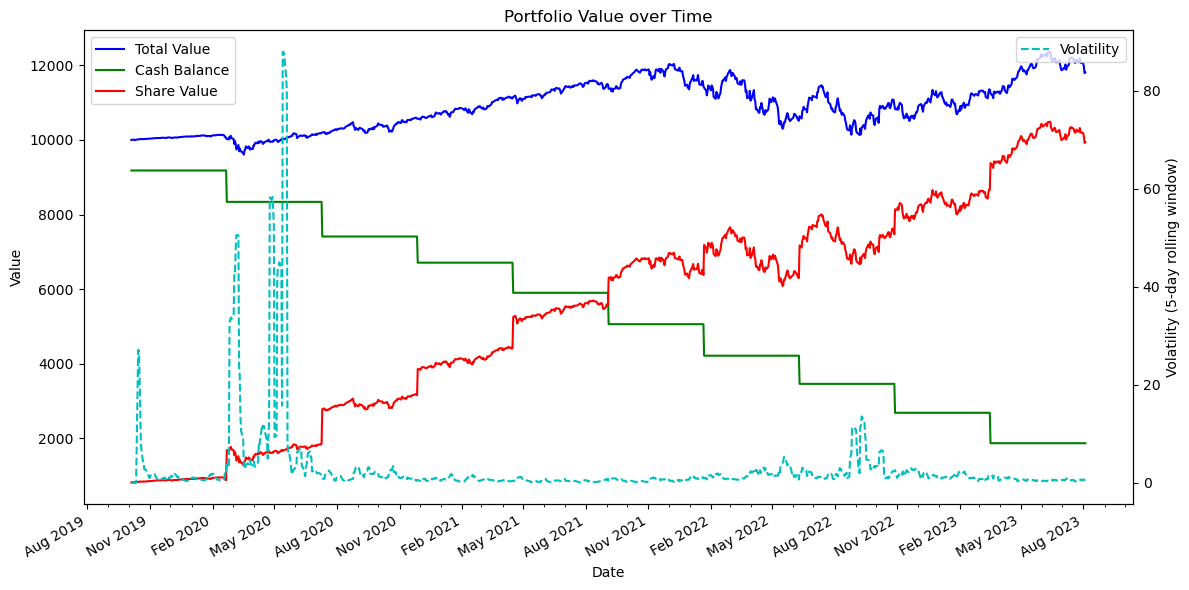

100%|██████████| 100/100 [09:35<00:00,  5.76s/it]


,Run 0,Run 1,Run 2,Run 3,Run 4
0,-1227.710730,-1276.001535,-1118.829227,-397.334460,-855.074918
1,-1228.954208,-1273.428159,-991.376025,-890.020010,-932.209329
2,-1169.725067,-1264.369162,-818.333160,-264.998236,-177.196585
3,-1181.513663,-1254.611401,-714.943356,-200.645868,-481.276129
4,-1158.197614,-1246.016357,-699.531354,1110.907974,2237.779205


,Run 0,Run 1,Run 2,Run 3,Run 4
95,3976.151215,4939.893341,4749.739487,5044.726624,5201.116226
96,4519.583984,5398.770340,4823.728943,5089.226364,5203.778519
97,4595.154617,5178.261551,4754.230179,5102.813766,5202.627457
98,5924.358826,5546.576950,5144.996017,5124.592361,5213.065445
99,4620.491852,5794.926880,4942.704086,5262.417358,5222.723373


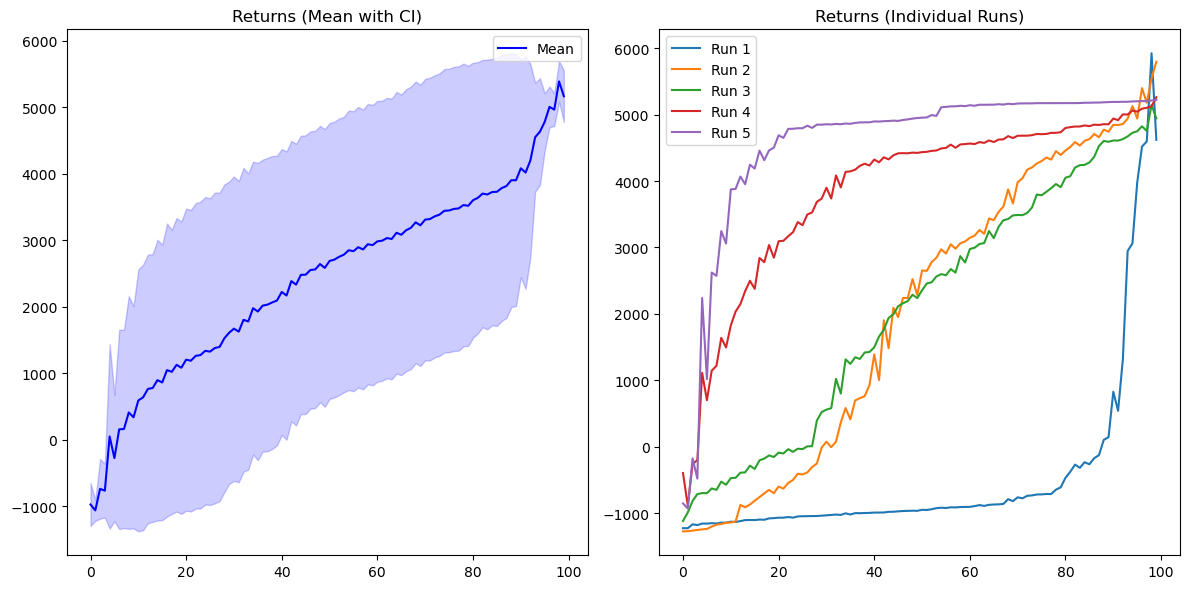

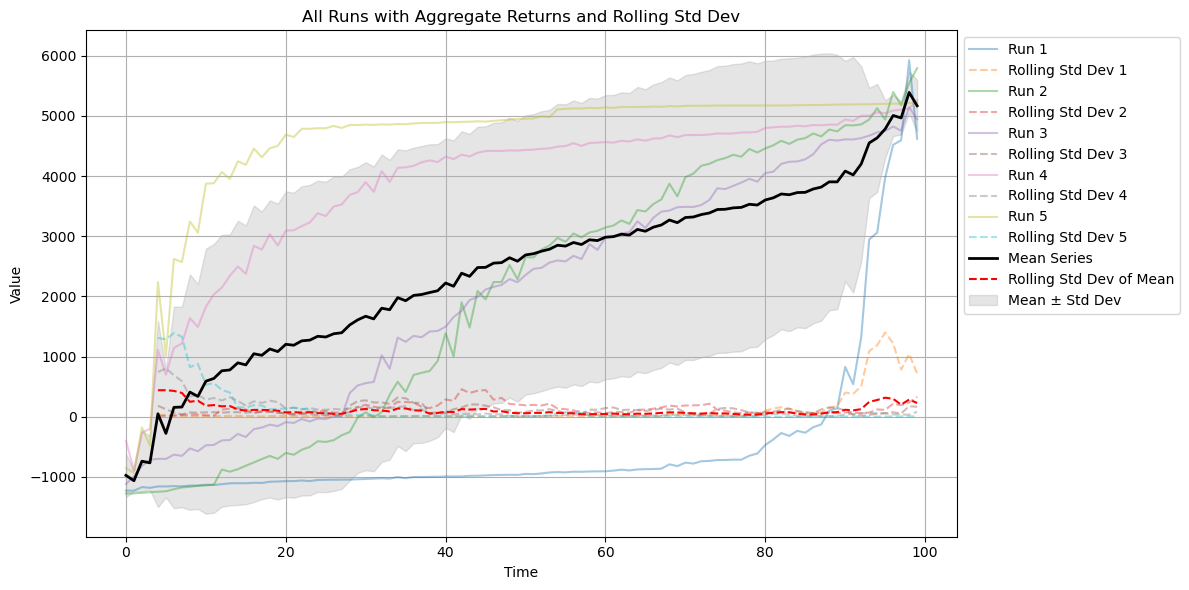

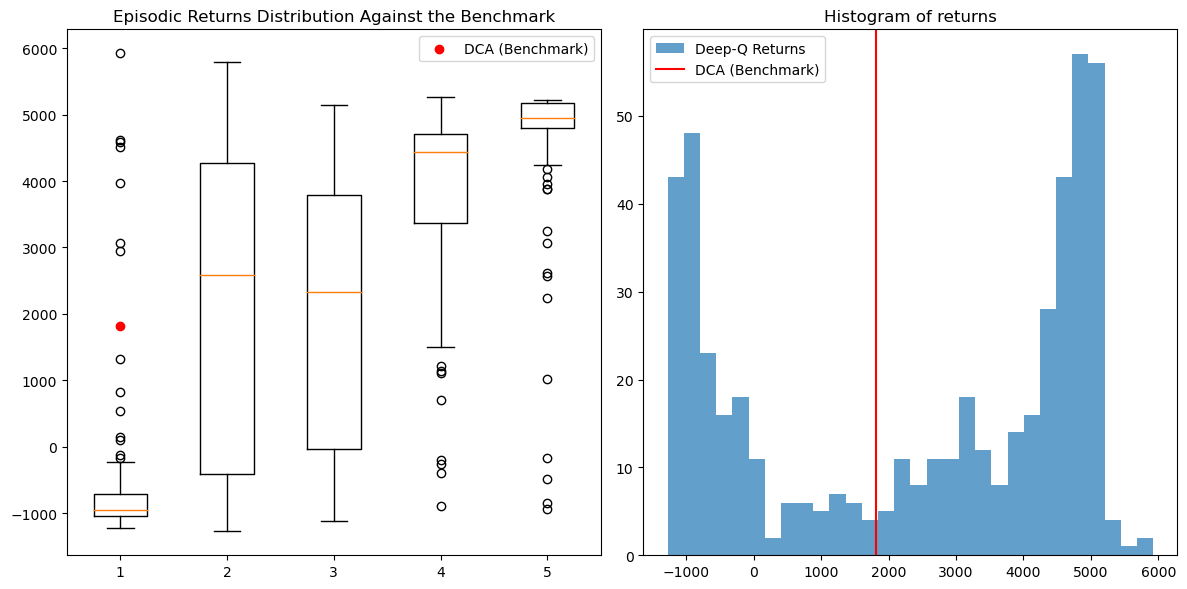

,Share Price,Shares Owned,Cash Balance,Share Value,Total Value,Returns,Volatility
0,53.692135,18,9033.541573,966.458427,10000.000000,0.000000,0.000000
1,55.197227,18,9033.541573,993.550095,10027.091667,27.091667,0.000000
2,55.209381,18,9033.541573,993.768860,10027.310432,27.310432,0.000000
3,54.562599,18,9033.541573,982.126785,10015.668358,15.668358,0.000000
4,55.202095,18,9033.541573,993.637711,10027.179283,27.179283,0.000000
...,...,...,...,...,...,...,...
995,177.970001,88,573.336853,15661.360107,16234.696960,6234.696960,0.571531
996,179.070007,88,573.336853,15758.160645,16331.497498,6331.497498,0.459439
997,175.490005,88,573.336853,15443.120483,16016.457336,6016.457336,0.570071
998,173.929993,88,573.336853,15305.839355,15879.176208,5879.176208,0.568814


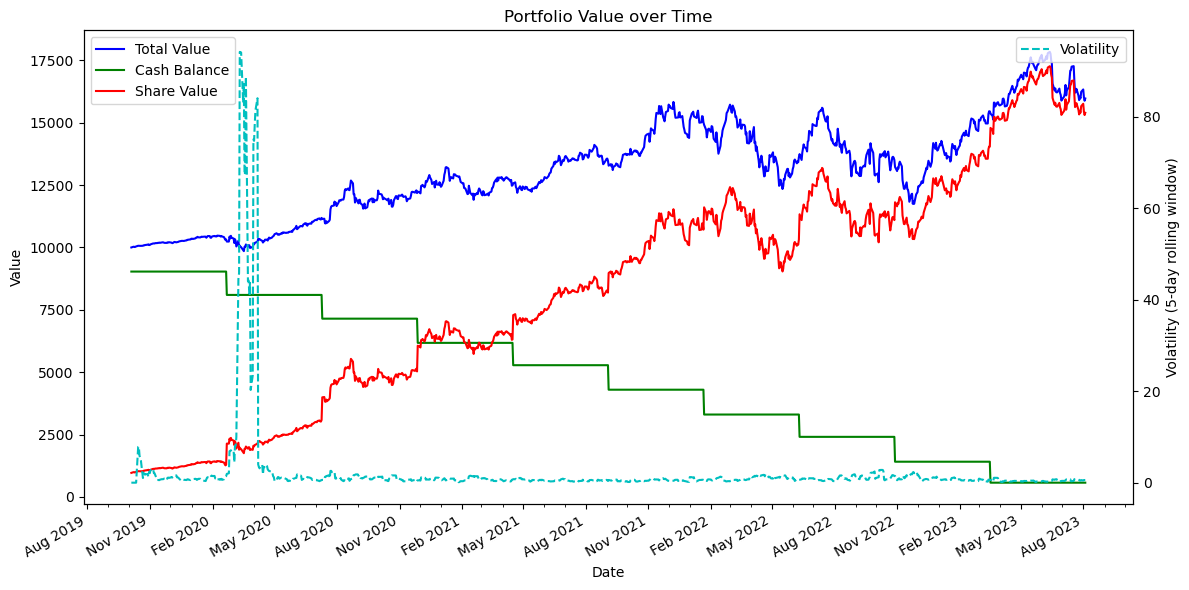

100%|██████████| 100/100 [09:50<00:00,  5.90s/it]


,Run 0,Run 1,Run 2,Run 3,Run 4
0,-1049.408524,-942.827497,-1047.807729,-818.417983,-1606.018129
1,-926.024814,6327.201206,-1129.494084,-1395.881744,-1666.676890
2,-616.113928,10174.138805,-620.007327,-675.653069,-1509.882666
3,-838.215175,10113.368225,-936.865435,-777.880948,-1530.874729
4,-485.858375,10333.531982,-241.743990,-558.798779,-1490.295551


,Run 0,Run 1,Run 2,Run 3,Run 4
95,16738.960907,19712.344715,16841.174812,17396.119717,17782.151855
96,17712.002026,19761.385094,16858.258224,17558.817383,18037.613239
97,17172.410278,19725.273815,17172.543709,17816.168159,17949.376366
98,18556.801956,19817.270927,17231.745712,17877.905945,18426.330566
99,18501.507904,19775.051632,18166.836044,18131.972500,18088.660194


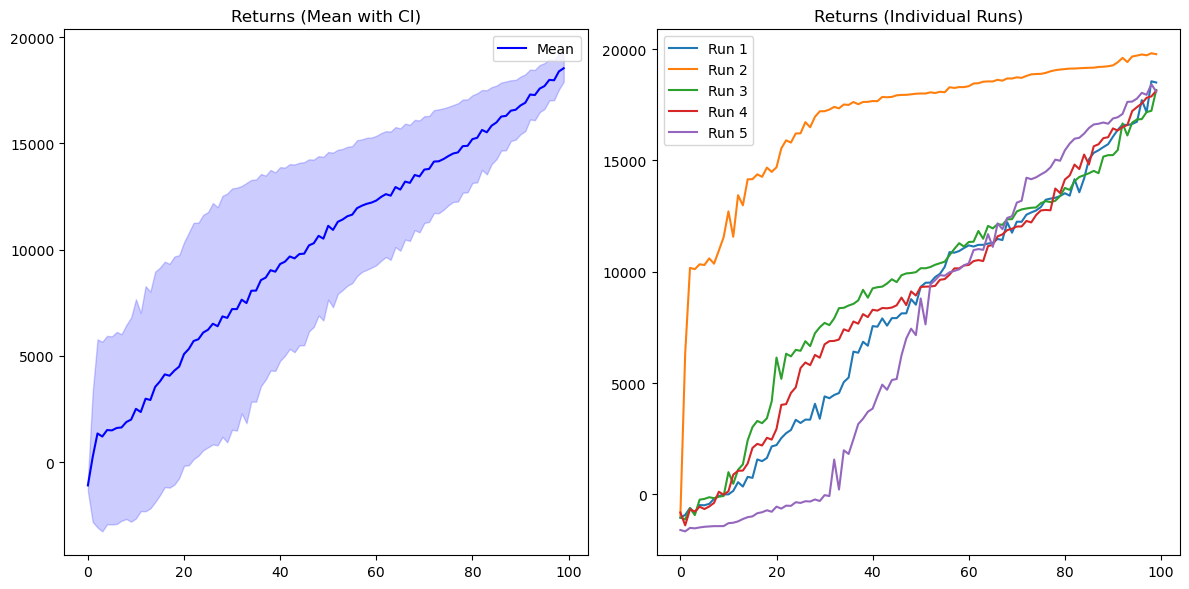

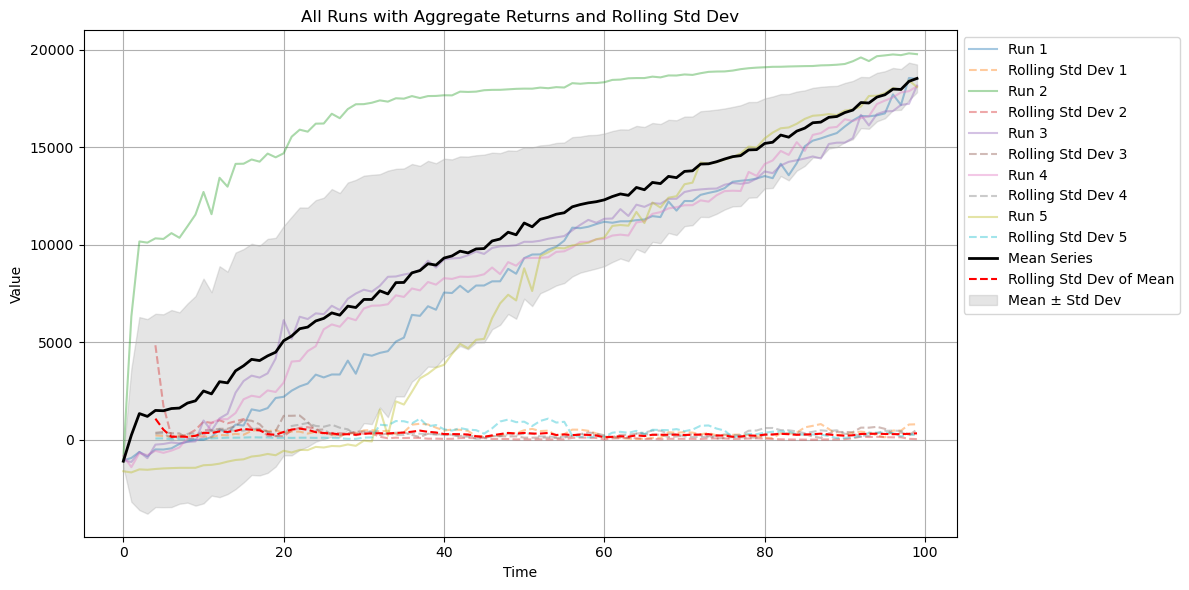

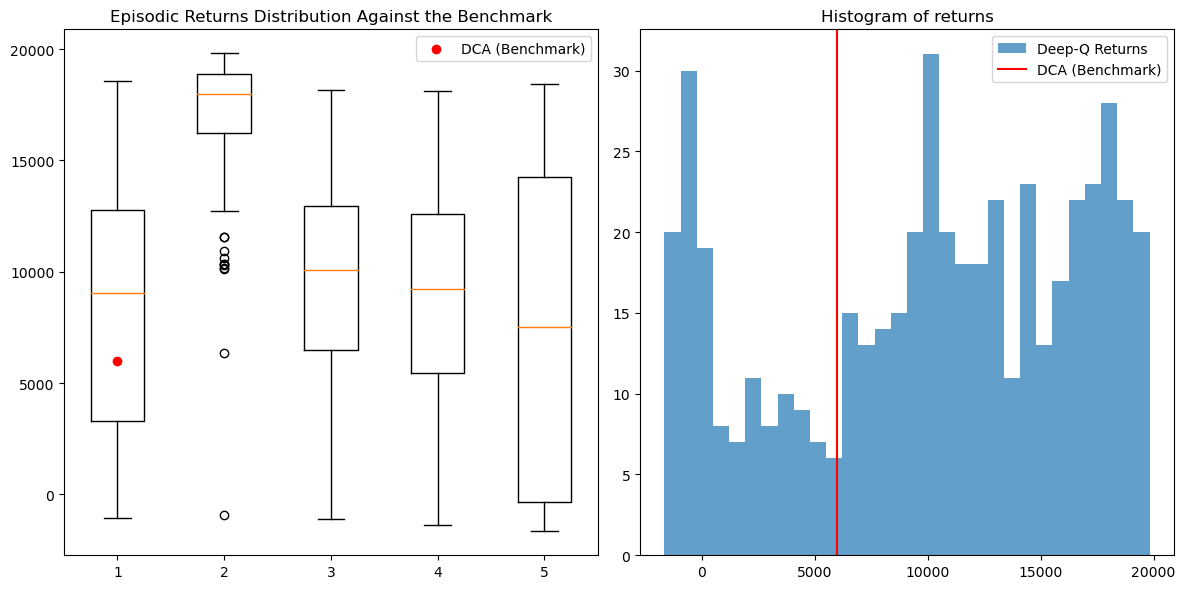

,Share Price,Shares Owned,Cash Balance,Share Value,Total Value,Returns,Volatility
0,131.144882,7,9081.985825,918.014175,10000.000000,0.000000,0.000000
1,132.915558,7,9081.985825,930.408905,10012.394730,12.394730,0.000000
2,131.953217,7,9081.985825,923.672516,10005.658340,5.658340,0.000000
3,130.557861,7,9081.985825,913.905029,9995.890854,-4.109146,0.000000
4,133.031021,7,9081.985825,931.217148,10013.202972,13.202972,0.000000
...,...,...,...,...,...,...,...
995,329.059998,41,1219.133484,13491.459900,14710.593384,4710.593384,0.712017
996,328.649994,41,1219.133484,13474.649750,14693.783234,4693.783234,0.636897
997,320.769989,41,1219.133484,13151.569550,14370.703033,4370.703033,0.646625
998,319.529999,41,1219.133484,13100.729950,14319.863434,4319.863434,0.524453


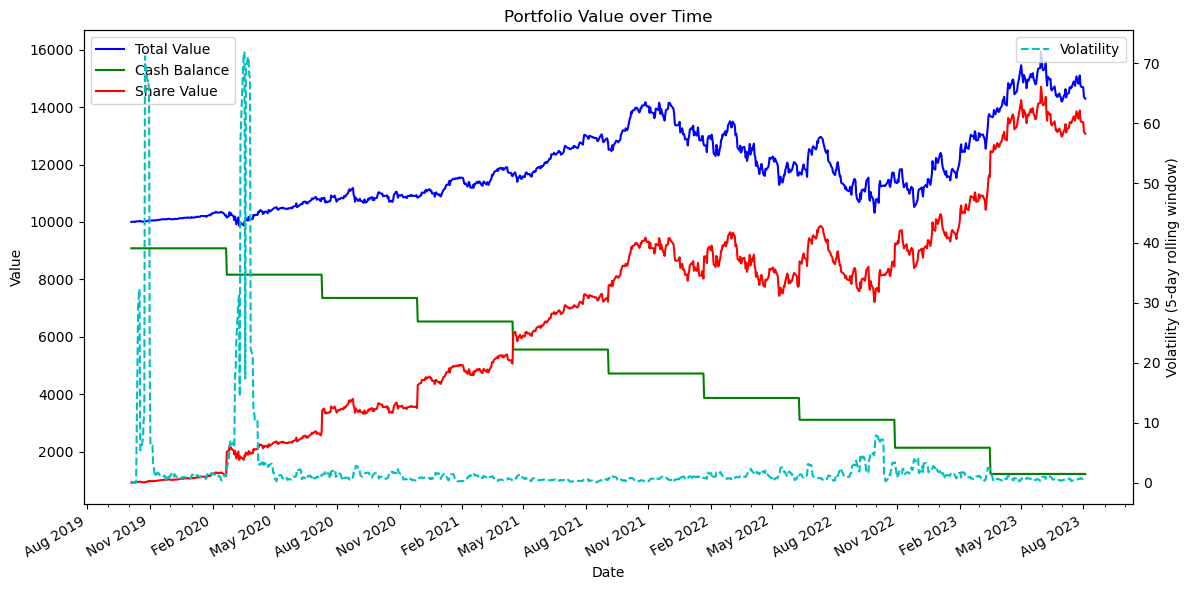

100%|██████████| 100/100 [07:30<00:00,  4.50s/it]


,Run 0,Run 1,Run 2,Run 3,Run 4
0,-1431.099667,-1449.130554,-841.752686,-692.253128,-1430.504810
1,-1465.463458,-1446.894635,-680.502039,-935.751910,-1460.088062
2,-1357.370740,-1440.809082,-632.582932,-626.173041,-1403.993130
3,-1416.619281,-1428.735760,-539.151727,-535.141040,-1415.723087
4,-1282.931366,-1422.770697,-527.883203,-189.958719,-1371.049081


,Run 0,Run 1,Run 2,Run 3,Run 4
95,11603.359695,4948.322540,11191.431366,10572.968323,10520.302689
96,11660.230927,9606.586502,11528.815689,11282.047897,11576.150803
97,11827.154465,6695.892929,11272.060257,11265.888702,11256.300552
98,12042.109741,11256.254440,12035.712646,12130.989441,12390.465408
99,12262.026199,10460.994995,11554.293671,11706.857803,11804.386536


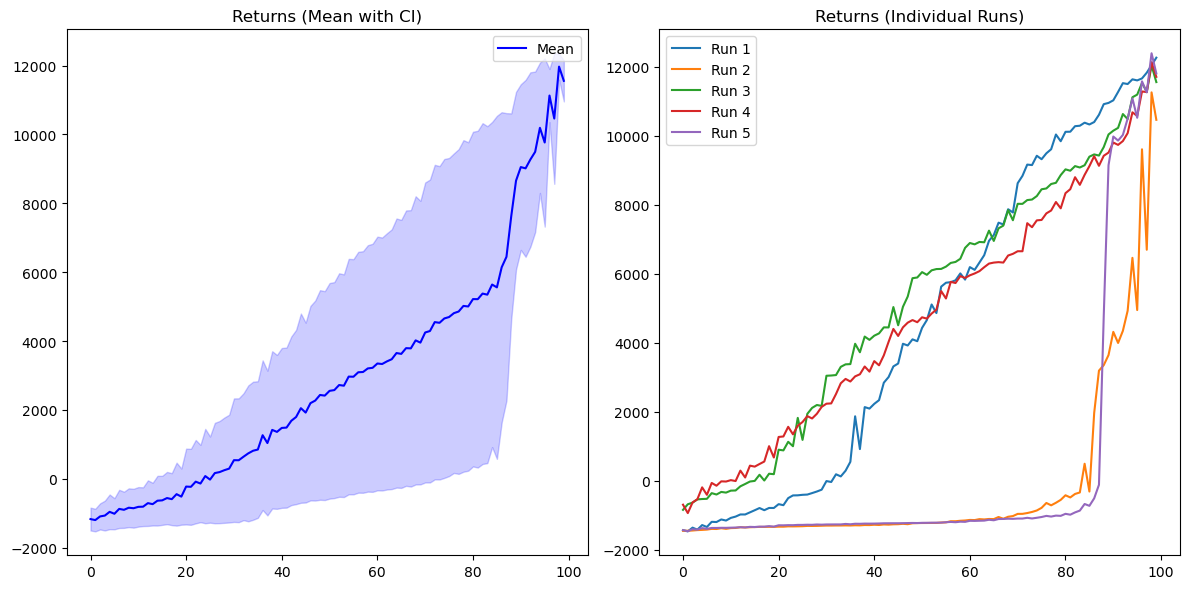

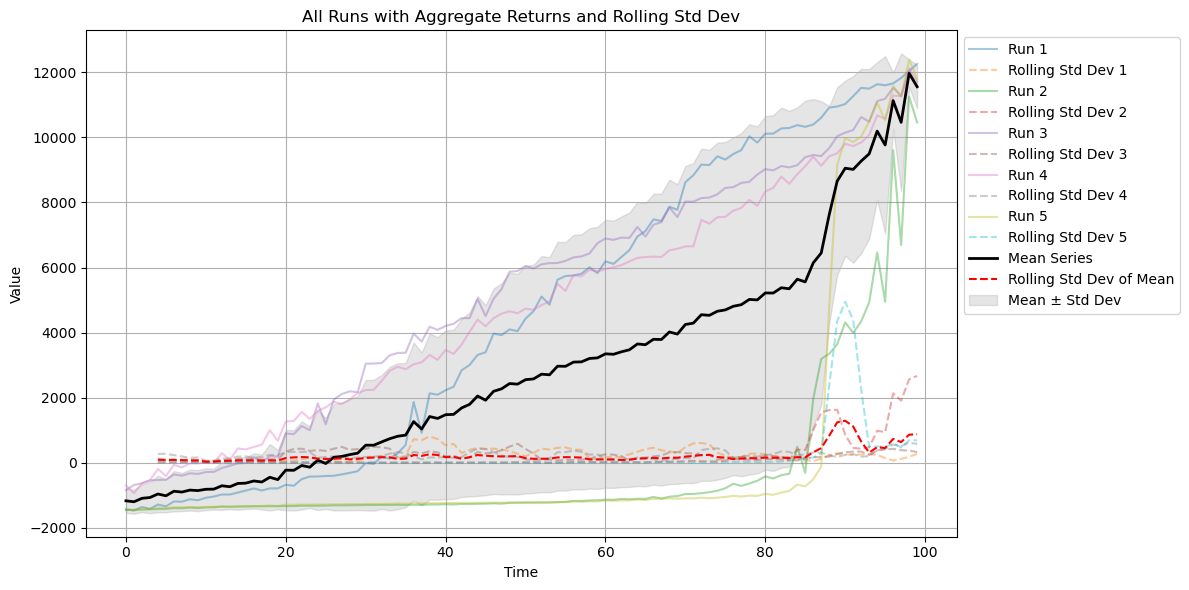

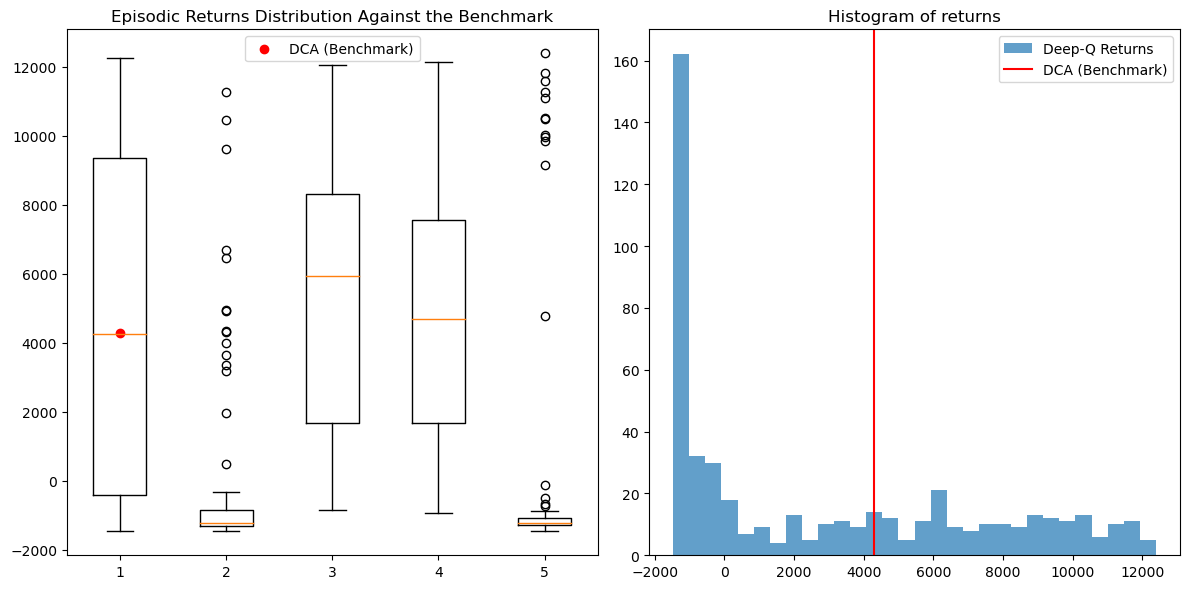

In [15]:
for ticker in tickers:
    display(HTML(f'<h2>{ticker}</h2>'))

    display(HTML(f'<h3>Dollar-Cost Averaging</h3>'))
    dca_overall_returns = evalute_dca(stock_dfs, ticker, investable_cash)

    display(HTML(f'<h3>DDQN</h3>'))
    ddqn_stats = rl_trade(stock_dfs[ticker], episodes=100, runs=5)
    visualize_ddqn_results(ticker, ddqn_stats, dca_overall_returns)

## Conclusions

Overall, the results show the surprising flexibility and effectiveness of the Deep Q learning method.

In particular, the machine learning-based method consistently beat DCA after only 10 training cycles. This rapid ascent underlines the financial potential of reinforcement learning. Unlike the static nature of DCA, the Deep Q-Learning model instantly understands the price patterns and volatility of stocks and optimises its decisions for higher returns. However, the returns also exhibit significant volatility across experiments, making this method less suitable for risk-averse investors.